<a href="https://colab.research.google.com/github/neSTORY/CartoonGAN_modified/blob/main/dropout_%26_batch_normailzation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dropout
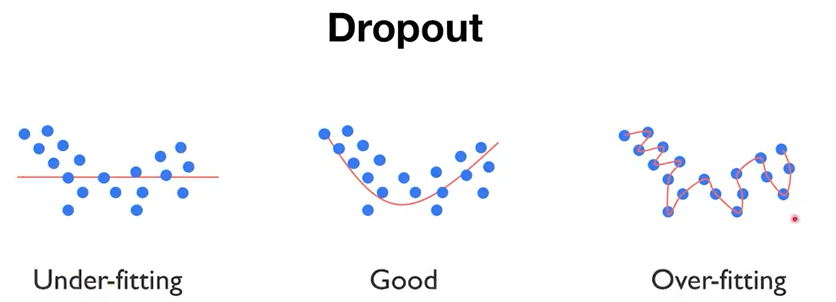

데이터의 분포가 위 그림과 같을 때 회귀선 3개가 다음과 같다면 왼쪽부터 과소적합, 적당, 과대적합이라고 한다.

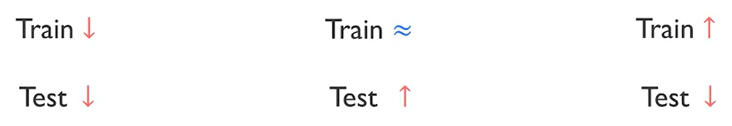

- under-fitiing의 경우 train이 덜 된 상태이고 test 데이터에 대한 정확도도 떨어진다.

- good fitting의 경우 train이 적절히 된 상태이고 test 데이터에 대한 정확도도 괜찮은 편이다.

- over-fitting의 경우 train이 많이 된 상태이고 test 데이터에 대한 정확도가 떨어진다.

 > 왜 과적합의 경우 train이 많이 된 상태인데 test 데이터에 대한 정확도가 떨어질까? <br>
  -> **train 데이터에 학습이 많이 맞춰져 있어서** test 데이터에 대한 정확도가 떨어진다.

Dropout은 이러한 과적합을 막아주는 regularization이라고 할 수 있다.

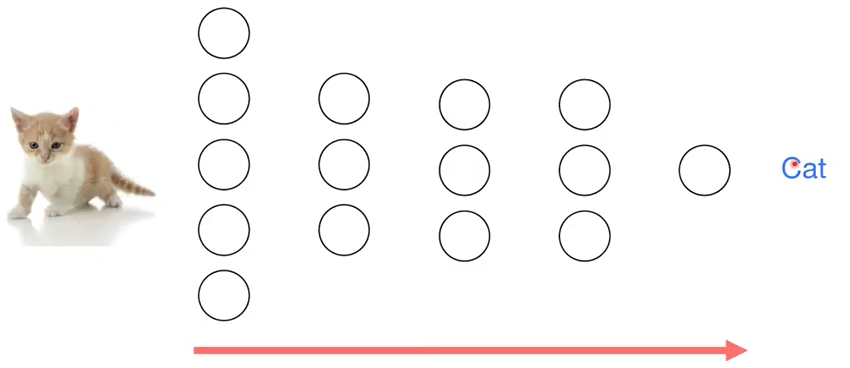

예를 들어 고양이를 판별해주는 네트워크의 구성이 위 그림과 같을 때

Dropout은 위 네트워크를 구성하는 뉴런(노드)들을 일부 비활성화 시켜주는 것이다.

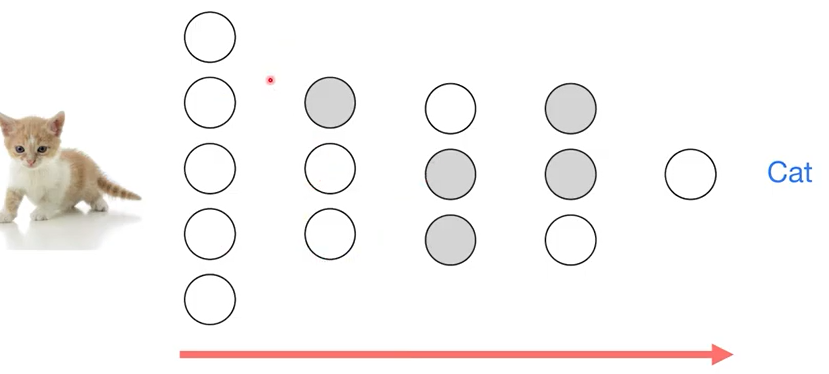

이때 비활성화 되는 뉴런은 랜덤하게 설정해준다. 비활성화 되는 뉴런의 비율을 설정해주는 것이 가능하다.

## code

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist
from time import time
import os

In [ ]:
def load(model, checkpoint_dir):
  print(" [*] Rading checkpoints >>>")
  
  ckpt = tf.train.get_checkpoint_state(checkpoint_dir)
  if ckpt:
    ckpt_name = os.path.basename(ckpt.model_checkpoint_path)
    checkpoint = tf.train.Checkpoint(dnn=model)
    checkpoint.restore(save_path=os.path.join(checkpoint_dir, ckpt_name))
    counter = int(ckpt_name.split("-")[1])

    print(" [*] Success to read {}".format(ckpt_name))

  else:
    print(" [*] Failed to find a checkpoint")

    return False, 0

def check_folder(dir):
  os.makedirs(dir, exist_ok=True)
  return dir

In [ ]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

X_train = X_train.astype(np.float32) / 255.0
y_train = to_categorical(y_train, 10)

X_test = X_test.astype(np.float32) / 255.0
y_test = to_categorical(y_test, 10)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)
(60000, 10) (10000, 10)


In [ ]:
def loss_fn(model, images, labels):
  logits = model(images, training=True)
  loss = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y_pred=logits,
                                                                 y_true=labels,
                                                                 from_logits=True))
  return loss

def accuracy_fn(model, images, labels):
  logits = model(images, training=False)
  prediction = tf.equal(tf.argmax(logits, -1), tf.argmax(labels, -1))
  accuracy = tf.reduce_mean(tf.cast(prediction, tf.float32))
  return accuracy

def grad(model, images, labels):
  with tf.GradientTape() as tape:
    loss = loss_fn(model, images, labels)

  return tape.gradient(loss, model.variables)

In [ ]:
from tensorflow.keras.layers import Flatten, Dense, Activation, Dropout

In [ ]:
def flatten() :
    return tf.keras.layers.Flatten()

def dense(label_dim, weight_init) :
    return tf.keras.layers.Dense(units=label_dim, activation="relu",use_bias=True, kernel_initializer=weight_init)

def relu() :
    return tf.keras.layers.Activation(tf.keras.activations.relu)

def dropout(rate) :
    return tf.keras.layers.Dropout(rate)

In [ ]:
def create_model_function(label_dim) :
    weight_init = tf.keras.initializers.glorot_uniform()

    model = tf.keras.Sequential()
    model.add(Flatten())

    for i in range(4) :
        model.add(Dense(units=512, activation="relu", kernel_initializer=weight_init))
        model.add(dropout(rate=0.5))

    model.add(Dense(label_dim, kernel_initializer=weight_init))

    return model

In [ ]:
lr = 1e-3
batch_size = 128

training_epochs=1
training_iterations = len(X_train)//batch_size

label_dim = 10
train_flag = True

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).\
  shuffle(buffer_size=100000).\
  prefetch(buffer_size=batch_size).\
  batch(batch_size, drop_remainder=True)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).\
  shuffle(buffer_size=100000).\
  prefetch(buffer_size=batch_size).\
  batch(len(X_test))

In [ ]:
network = create_model_function(label_dim)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

In [ ]:
epochs = 2
start_iteration = 0

for i in range(2):
  for idx, (train_input, train_label) in enumerate(train_dataset):
    start_time = time()
    grads = grad(network, train_input, train_label)
    optimizer.apply_gradients(grads_and_vars=zip(grads, network.variables))
    
    train_loss = loss_fn(network, train_input, train_label)
    train_accuracy = accuracy_fn(network, train_input, train_label)
    
    for test_input, test_label in test_dataset:
      test_accuracy = accuracy_fn(network, test_input, test_label)

    print("Epoch : [{:3}] [{:5}/{:5}] time : {:4.2f}s, train_loss : {:8.4f}, train_accuracy: {:8.4f}, test_accuracy: {:8.4f}".\
          format(i+1, idx, training_iterations, time()-start_time, train_loss, train_accuracy, test_accuracy))

Epoch : [  1] [    0/  468] time : 0.22s, train_loss :   0.6268, train_accuracy:   0.8828, test_accuracy:   0.8776
Epoch : [  1] [    1/  468] time : 0.21s, train_loss :   0.7910, train_accuracy:   0.8828, test_accuracy:   0.8796
Epoch : [  1] [    2/  468] time : 0.19s, train_loss :   0.6784, train_accuracy:   0.8281, test_accuracy:   0.8774
Epoch : [  1] [    3/  468] time : 0.10s, train_loss :   0.6396, train_accuracy:   0.8672, test_accuracy:   0.8756
Epoch : [  1] [    4/  468] time : 0.09s, train_loss :   0.7105, train_accuracy:   0.8828, test_accuracy:   0.8732
Epoch : [  1] [    5/  468] time : 0.10s, train_loss :   0.7417, train_accuracy:   0.8750, test_accuracy:   0.8744
Epoch : [  1] [    6/  468] time : 0.10s, train_loss :   0.5394, train_accuracy:   0.8750, test_accuracy:   0.8798
Epoch : [  1] [    7/  468] time : 0.10s, train_loss :   0.7232, train_accuracy:   0.8516, test_accuracy:   0.8856
Epoch : [  1] [    8/  468] time : 0.09s, train_loss :   0.6327, train_accuracy:

KeyboardInterrupt: ignored

## Batch Normalization

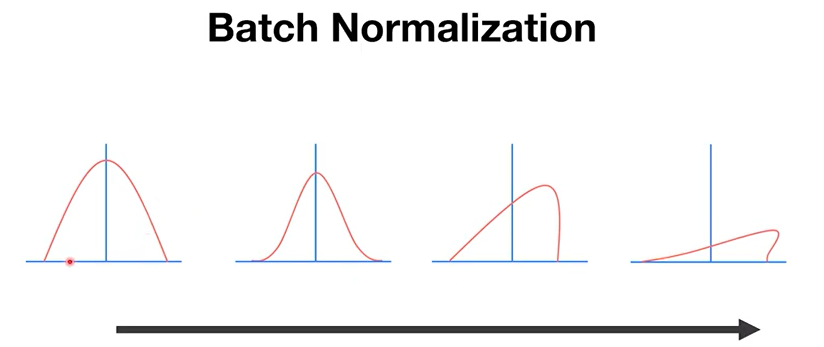

데이터의 분포가 맨 왼쪽 그림과 같다면 layer를 거칠때 마다 데이터의 분포는 위 그림처럼 변하게 된다.

이러한 현상을 `Internal Covariate Shift`라고 부른다.

Batch Normalization은 이러한 현상을 막고자 하는 것이다.

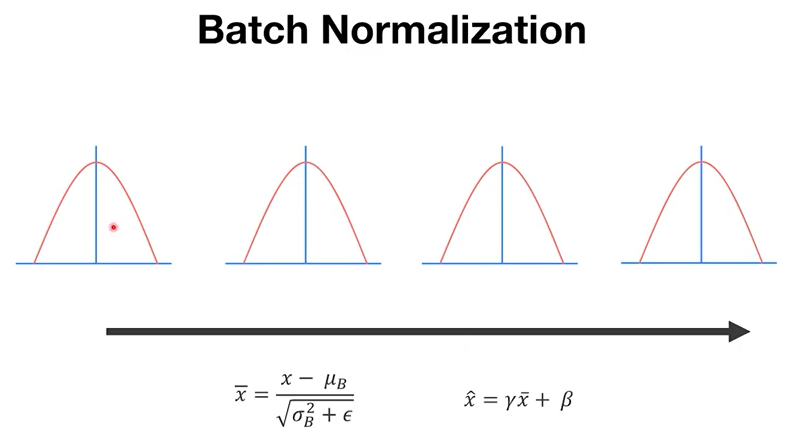

- 이를 위해서 레이어마다 데이터의 평균을 빼고 표준편차의 제곱에 특정 값을 더해 표준화를 시켜준다. -> x-bar 만들기
- x-bar에 다시 r값을 곱하고 학습이 가능한 파라미터 beta값을 더해줘서 x-hat을 만들고 이 값을 다음 레이어의 인풋으로 넣어준다.
- 이러한 과정을 거치면 데이터의 분포가 위 그림처럼 정규화가 되어진다.

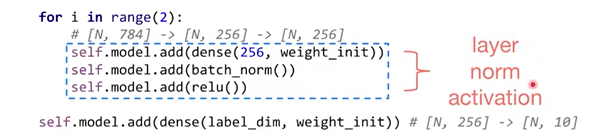

네트워크의 구성 순서는 보통
- Layer
- normalization
- activation
순서대로 간다.

코드는 3번이나 반복했기 때문에 이번에는 생략한다..